In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'CAD=X'
numbers_in_currency = 'USD'
share_name = 'AG.TO'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-06-30,67,-43,24,8,65,8,24,118,0,...,16,0,36,72,49,298,27,-27,117.4,2014-08-04
1,2014-09-30,41,-32,9,-11,33,7,33,88,0,...,21,0,38,76,42,291,5,-26,117.4,2014-11-04
2,2014-12-31,73,-45,28,-65,40,5,18,75,0,...,26,0,38,78,30,251,42,-26,117.4,2015-02-19
3,2015-03-31,55,-32,22,-1,22,8,17,62,0,...,21,0,39,75,21,236,6,-12,129.1,2015-05-05
4,2015-06-30,54,-33,21,-3,21,7,16,72,0,...,22,0,36,73,18,223,21,-19,129.1,2015-08-04


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2023-06-30,2023-08-04,277.20,147,-137,9,-18,160,5,58,...,0,2014,36,0,17,126,214,638,20,-37
37,2023-09-30,2023-11-04,277.20,133,-120,13,-27,138,9,61,...,0,1952,22,0,17,100,217,613,20,-34
38,2023-12-31,2024-02-19,277.20,137,-119,18,10,126,10,64,...,0,1976,94,0,18,120,219,618,25,-26
39,2024-03-31,2024-05-06,287.21,106,-80,26,-14,102,7,67,...,0,1955,98,0,18,120,221,615,12,-30
40,2024-06-30,2024-07-29,292.02,136,-120,16,-48,152,14,68,...,0,1987,92,0,18,112,223,613,17,-27


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-06-30,2023-08-04,277.20,147,-137,9,-18,160,5,58,...,2014,36,0,17,126,214,638,20,-37,1.343352
37,2023-09-30,2023-11-04,277.20,133,-120,13,-27,138,9,61,...,1952,22,0,17,100,217,613,20,-34,1.341033
38,2023-12-31,2024-02-19,277.20,137,-119,18,10,126,10,64,...,1976,94,0,18,120,219,618,25,-26,1.361617
39,2024-03-31,2024-05-06,287.21,106,-80,26,-14,102,7,67,...,1955,98,0,18,120,221,615,12,-30,1.347550
40,2024-06-30,2024-07-29,292.02,136,-120,16,-48,152,14,68,...,1987,92,0,18,112,223,613,17,-27,1.367756


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-06-30,2023-08-04,277.20,197.472703,-184.039186,12.090166,-24.180331,214.936276,6.716759,77.914400,...,2705.510371,48.360662,0.0,22.836979,169.262317,287.477269,857.058400,26.867034,-49.704014,1.343352
37,2023-09-30,2023-11-04,277.20,178.357379,-160.923951,17.433428,-36.207889,185.062543,12.069296,81.803008,...,2617.696266,29.502724,0.0,22.797560,134.103292,291.004144,822.053182,26.820658,-45.595119,1.341033
38,2023-12-31,2024-02-19,277.20,186.541582,-162.032469,24.509113,13.616174,171.563791,13.616174,87.143513,...,2690.555961,127.992035,0.0,24.509113,163.394087,298.194208,841.479546,34.040435,-35.402052,1.361617
39,2024-03-31,2024-05-06,287.21,142.840333,-107.804025,35.036308,-18.865704,137.450132,9.432852,90.285871,...,2634.460862,132.059931,0.0,24.255906,161.706038,297.808619,828.743443,16.170604,-40.426509,1.347550
40,2024-06-30,2024-07-29,292.02,186.014836,-164.130738,21.884098,-65.652295,207.898935,19.148586,93.007418,...,2717.731471,125.833566,0.0,24.619611,153.188689,305.009622,838.434520,23.251855,-36.929416,1.367756


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-08-04,11.687811,2014-06-30,73.116588,0.0,5.512235,117.4,0.0,0.0,70.934003,...,0.665544,0.334456,0.0,0.0,0.0,0.0,0.358209,0.119403,0.0,0.0
1,2014-08-11,10.637890,2014-06-30,73.116588,0.0,5.512235,117.4,0.0,0.0,70.934003,...,0.665544,0.334456,0.0,0.0,0.0,0.0,0.358209,0.119403,0.0,0.0
2,2014-08-18,10.677509,2014-06-30,73.116588,0.0,5.512235,117.4,0.0,0.0,70.934003,...,0.665544,0.334456,0.0,0.0,0.0,0.0,0.358209,0.119403,0.0,0.0
3,2014-08-25,11.034085,2014-06-30,73.116588,0.0,5.512235,117.4,0.0,0.0,70.934003,...,0.665544,0.334456,0.0,0.0,0.0,0.0,0.358209,0.119403,0.0,0.0
4,2014-09-01,10.330839,2014-06-30,73.116588,0.0,5.512235,117.4,0.0,0.0,70.934003,...,0.665544,0.334456,0.0,0.0,0.0,0.0,0.358209,0.119403,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-08-04,11.687811,2014-06-30,73.116588,0.0,5.512235,117.4,0.0,0.0,70.934003,...,0.0,0.358209,0.119403,0.0,0.0,inf,2.120340,inf,inf,inf
1,2014-08-11,10.637890,2014-06-30,73.116588,0.0,5.512235,117.4,0.0,0.0,70.934003,...,0.0,0.358209,0.119403,0.0,0.0,inf,1.929869,inf,inf,inf
2,2014-08-18,10.677509,2014-06-30,73.116588,0.0,5.512235,117.4,0.0,0.0,70.934003,...,0.0,0.358209,0.119403,0.0,0.0,inf,1.937056,inf,inf,inf
3,2014-08-25,11.034085,2014-06-30,73.116588,0.0,5.512235,117.4,0.0,0.0,70.934003,...,0.0,0.358209,0.119403,0.0,0.0,inf,2.001744,inf,inf,inf
4,2014-09-01,10.330839,2014-06-30,73.116588,0.0,5.512235,117.4,0.0,0.0,70.934003,...,0.0,0.358209,0.119403,0.0,0.0,inf,1.874165,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

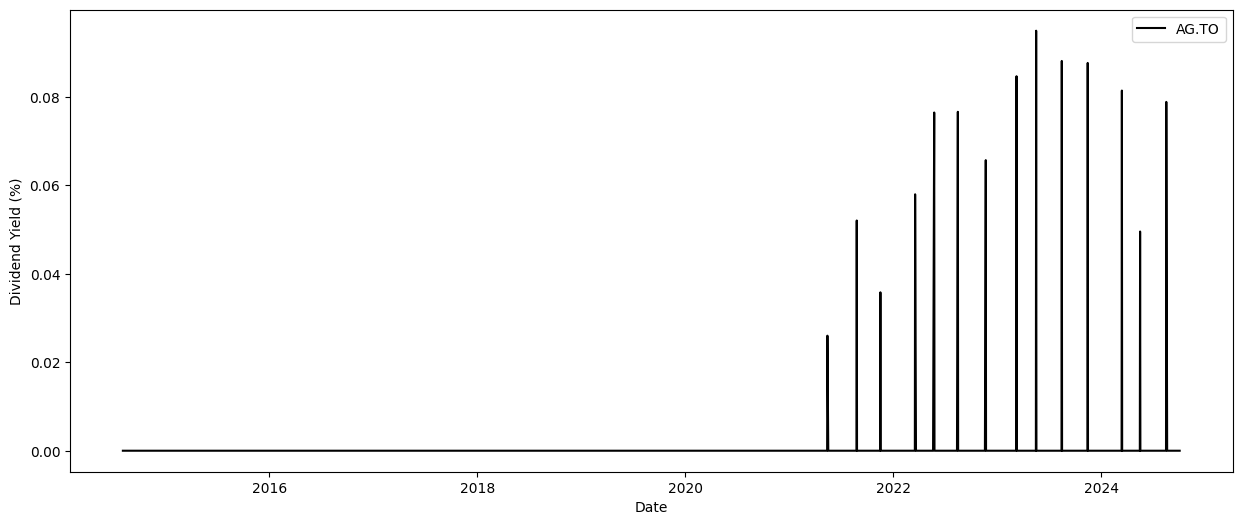

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   -0.156197
share_price      1.000000
Name: share_price, dtype: float64


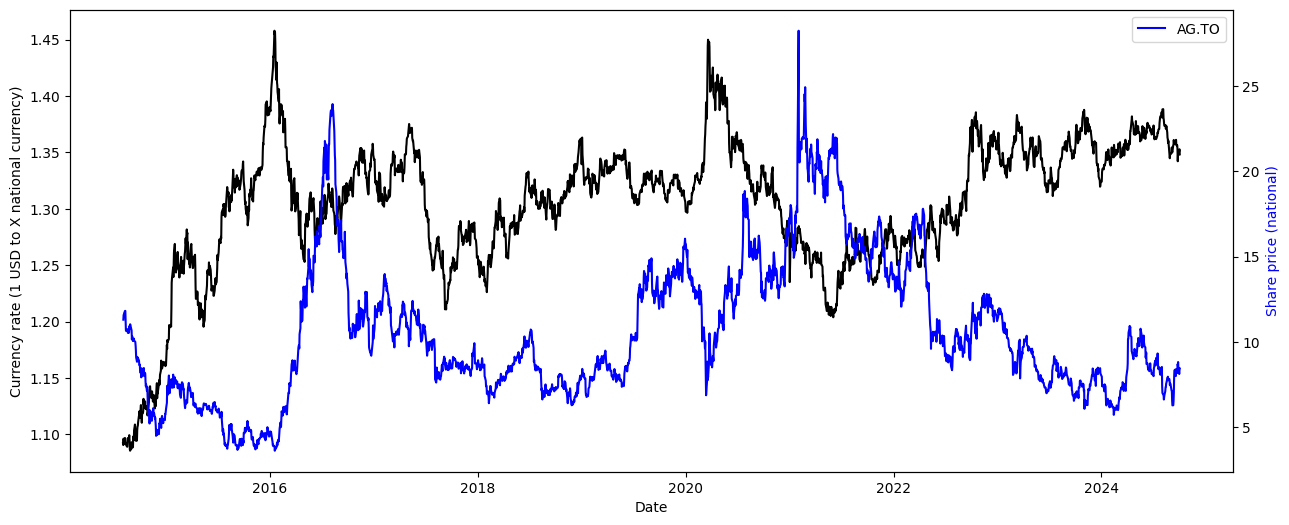

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

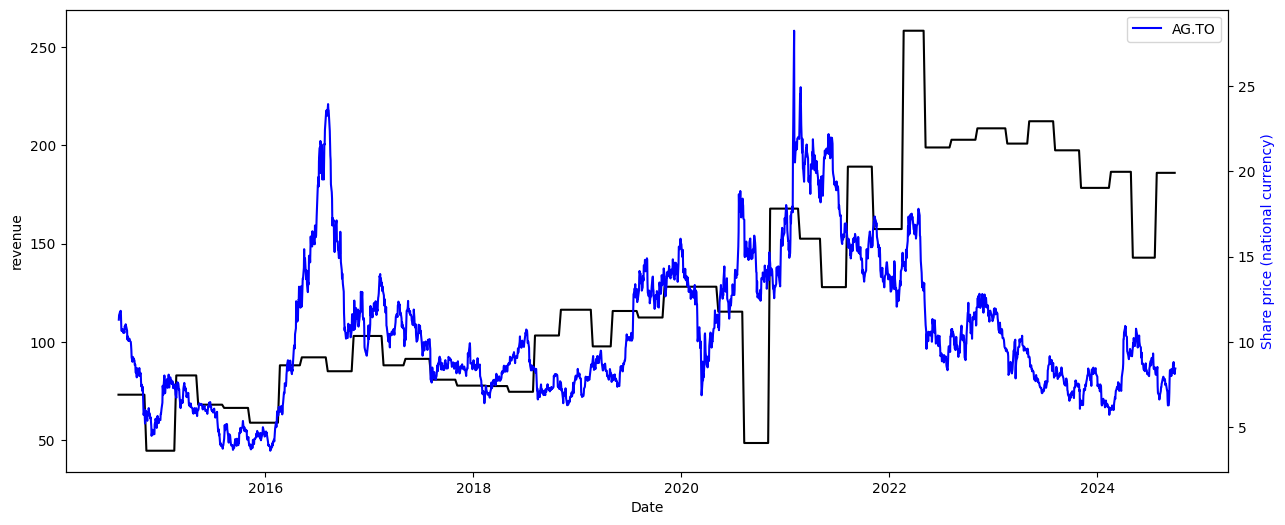

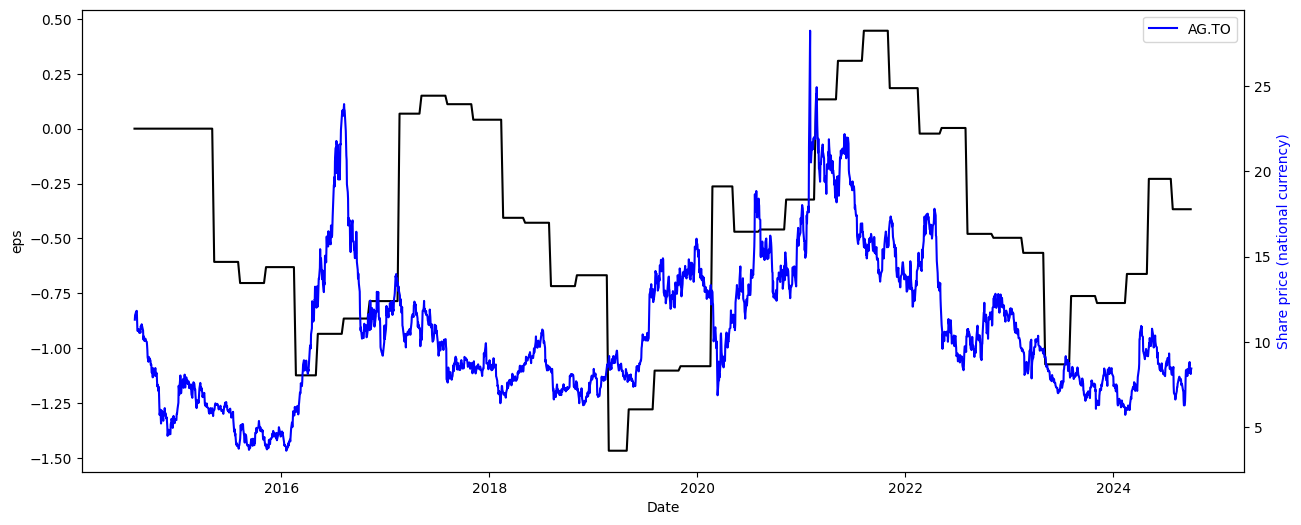

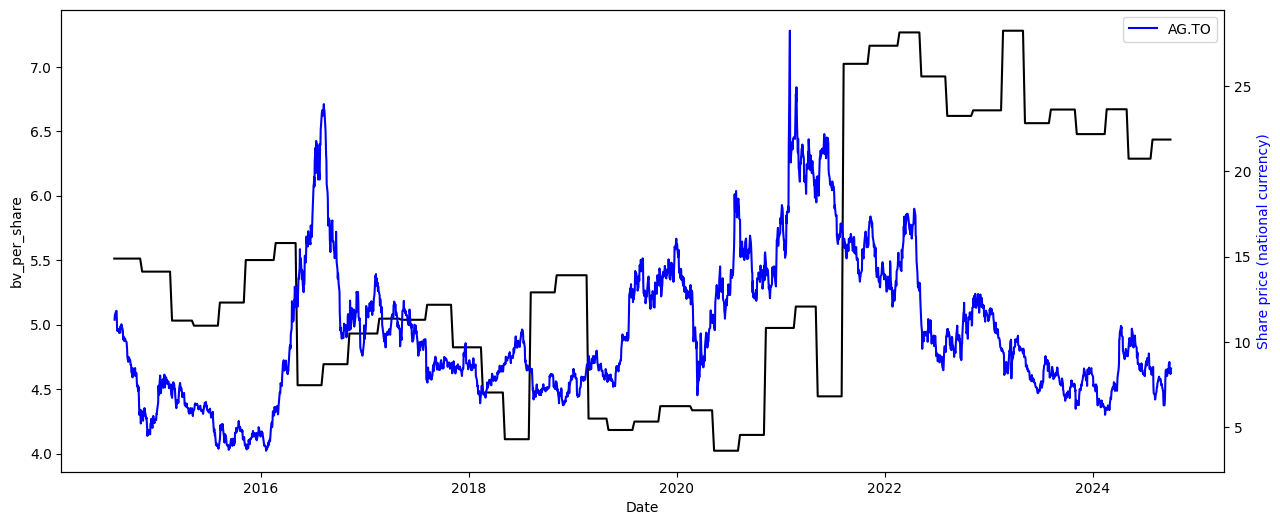

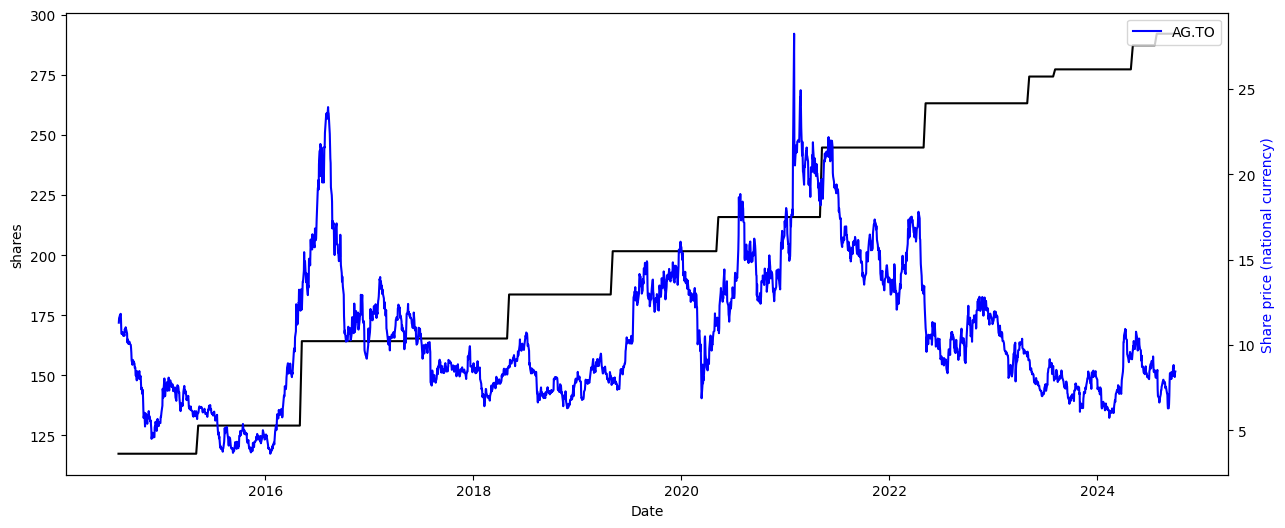

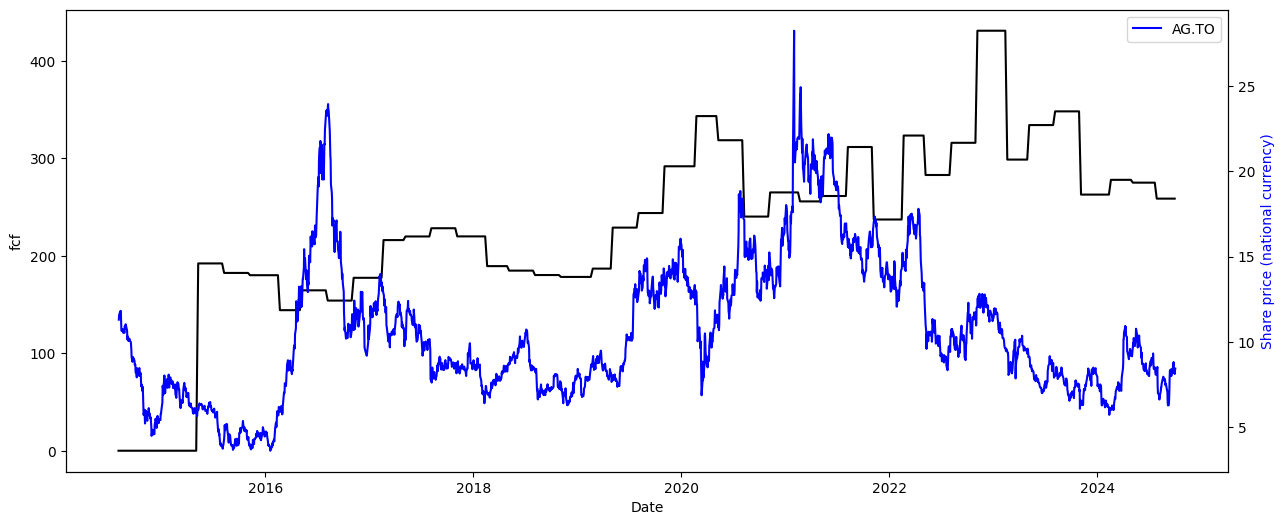

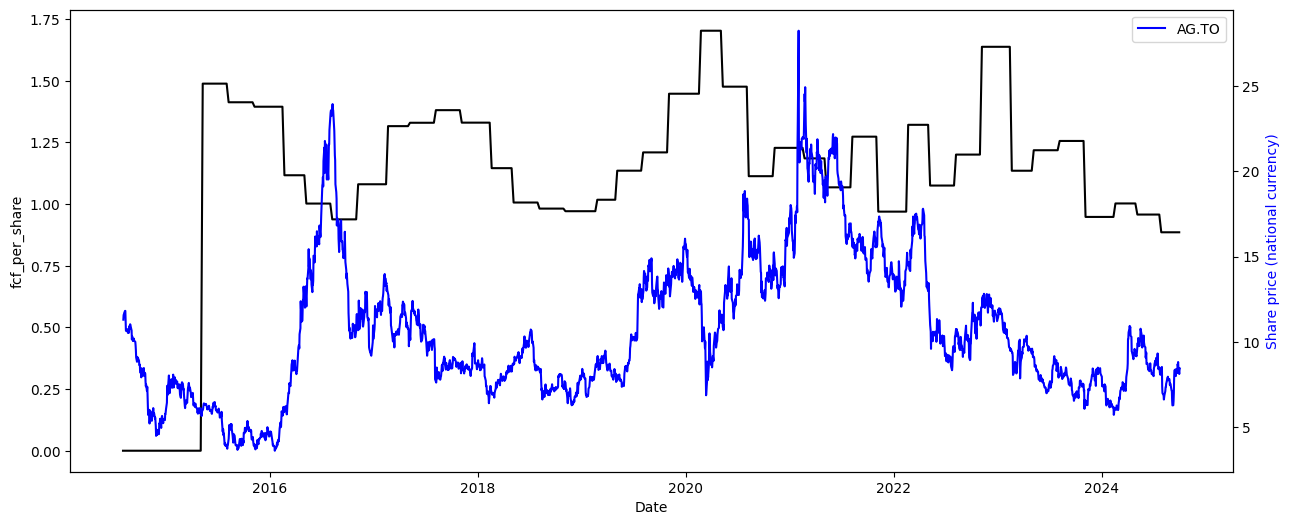

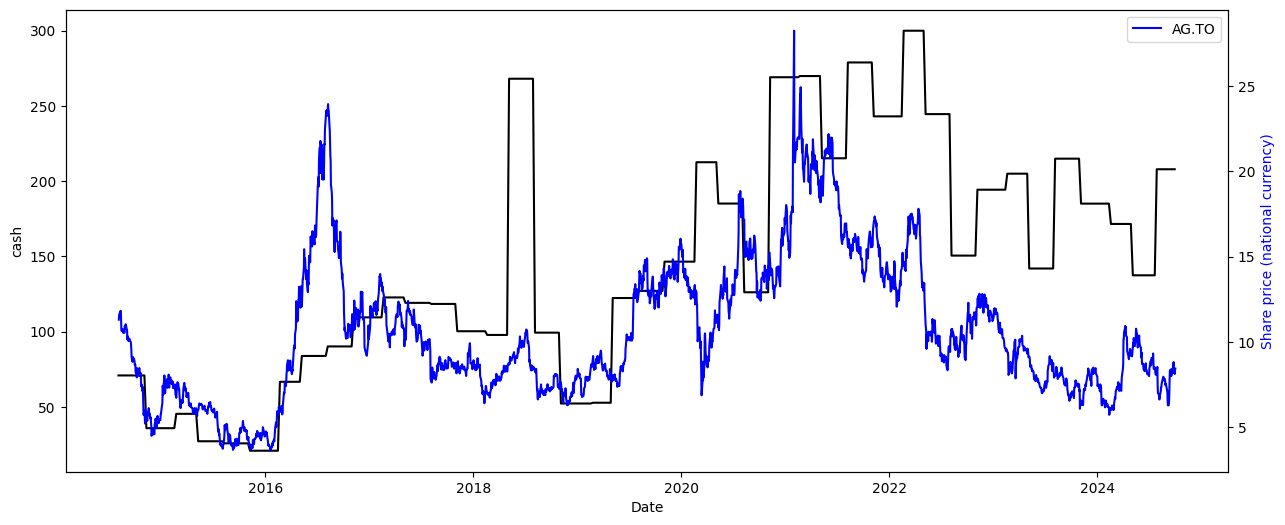

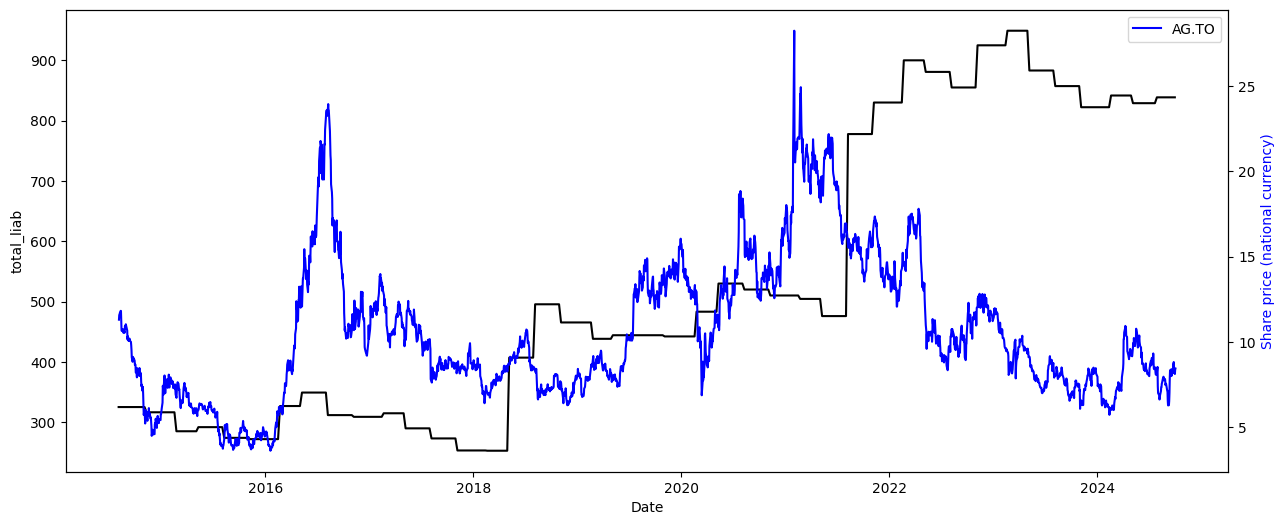

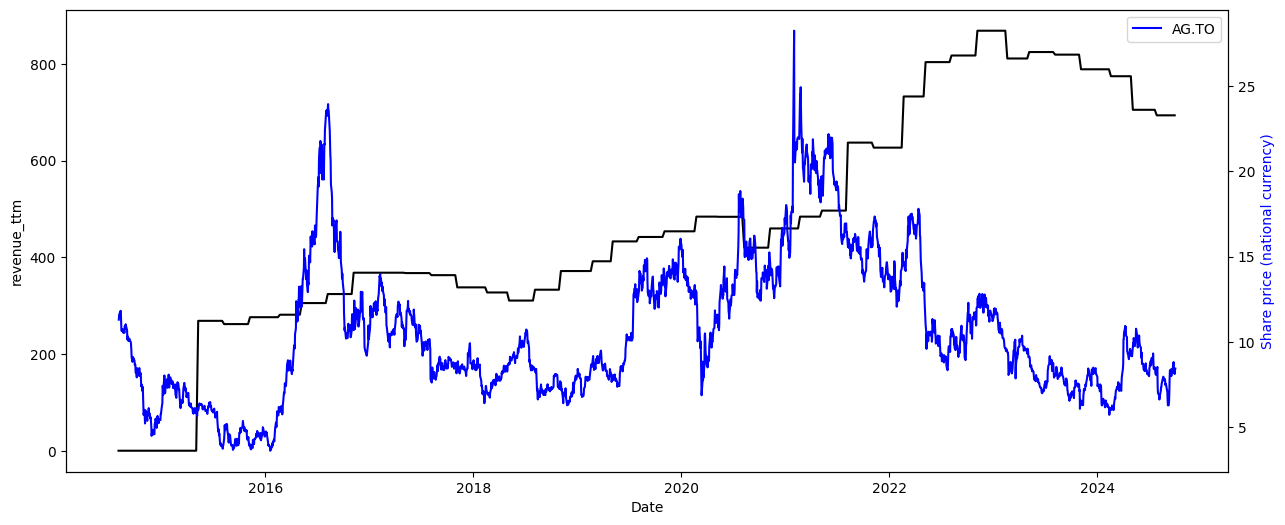

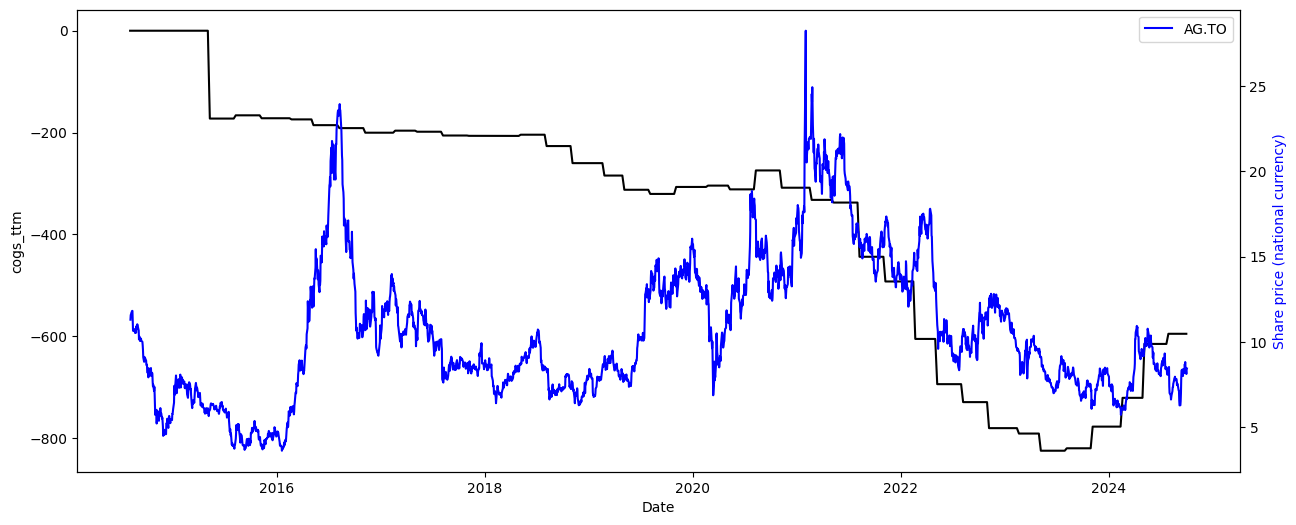

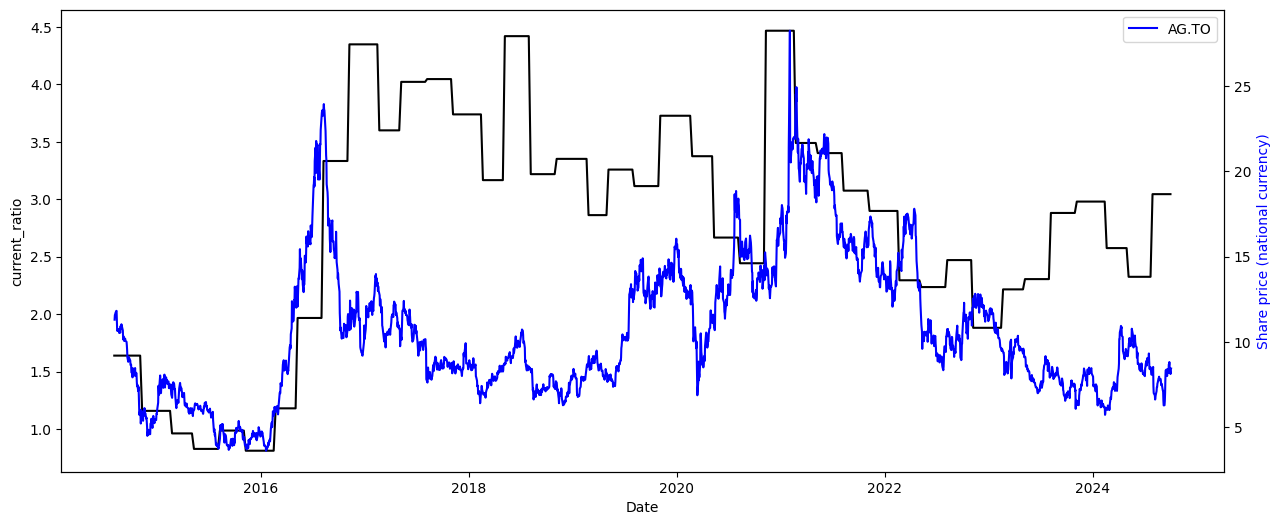

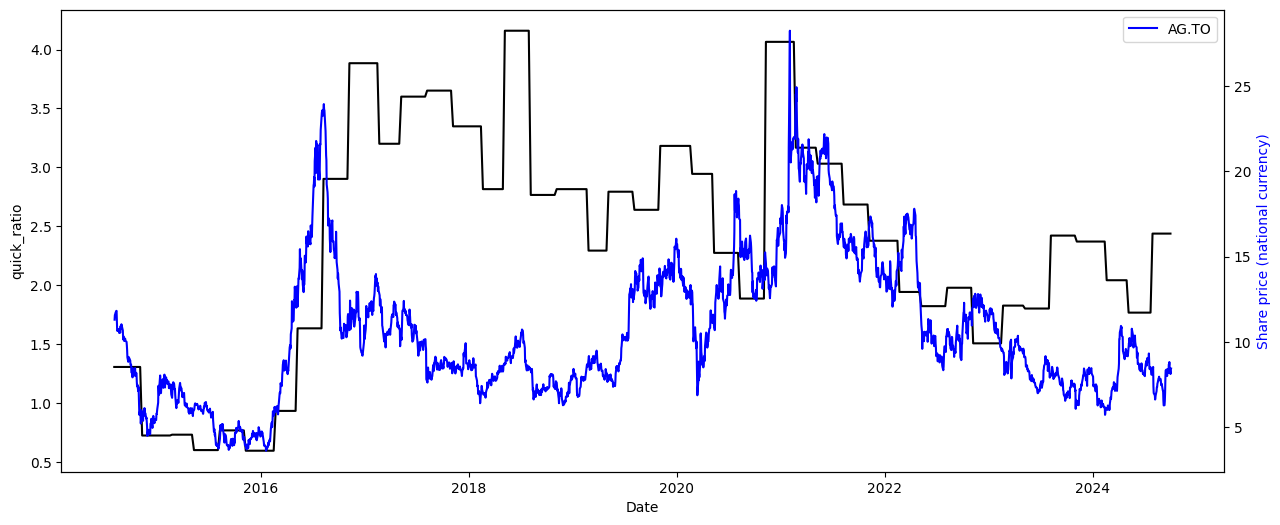

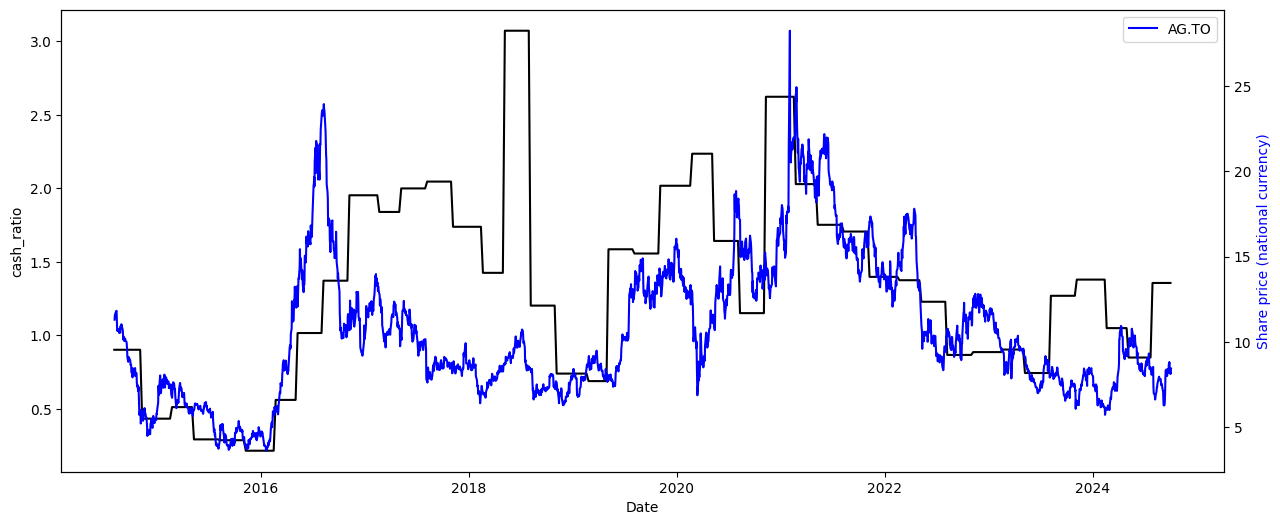

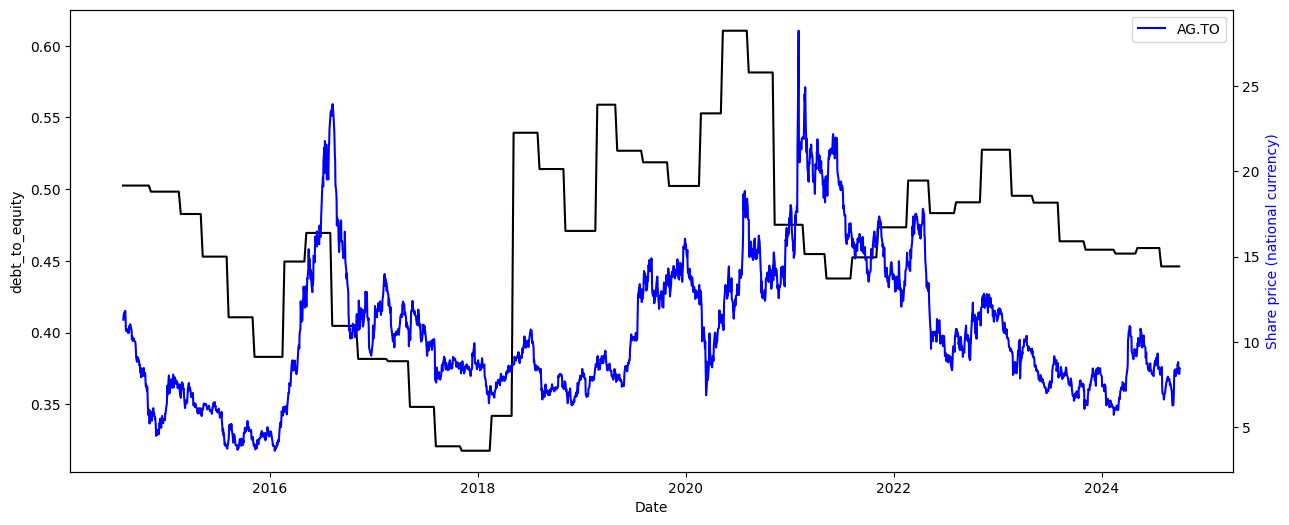

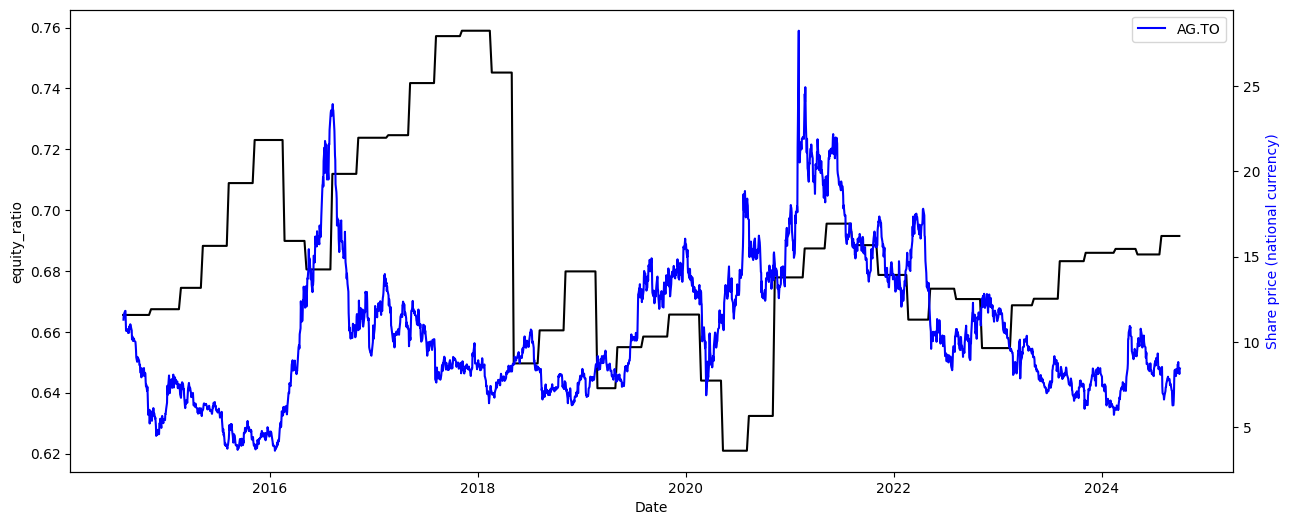

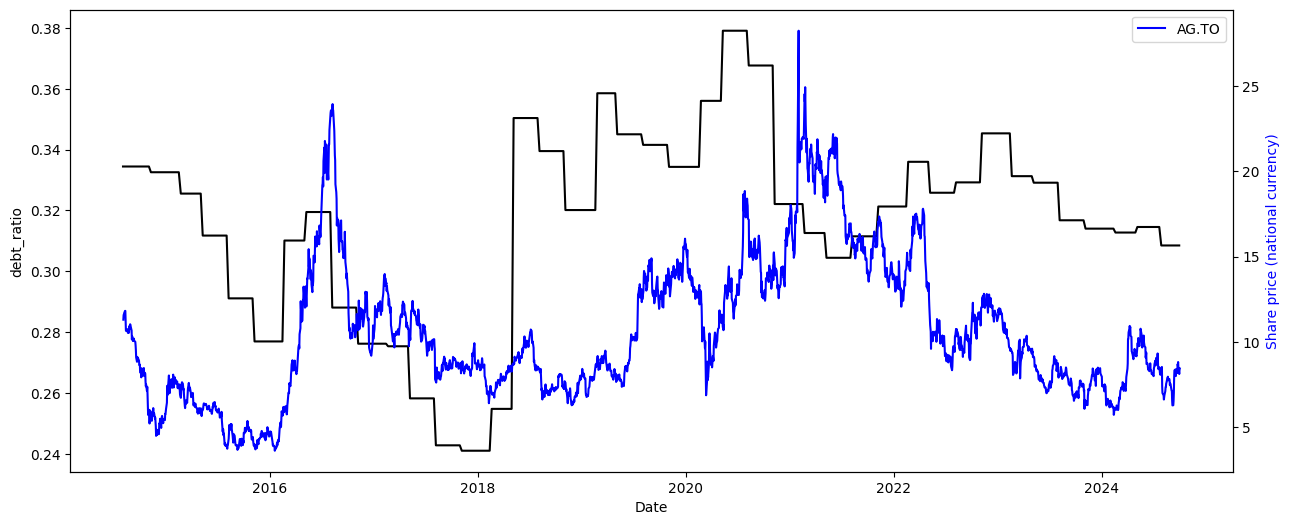

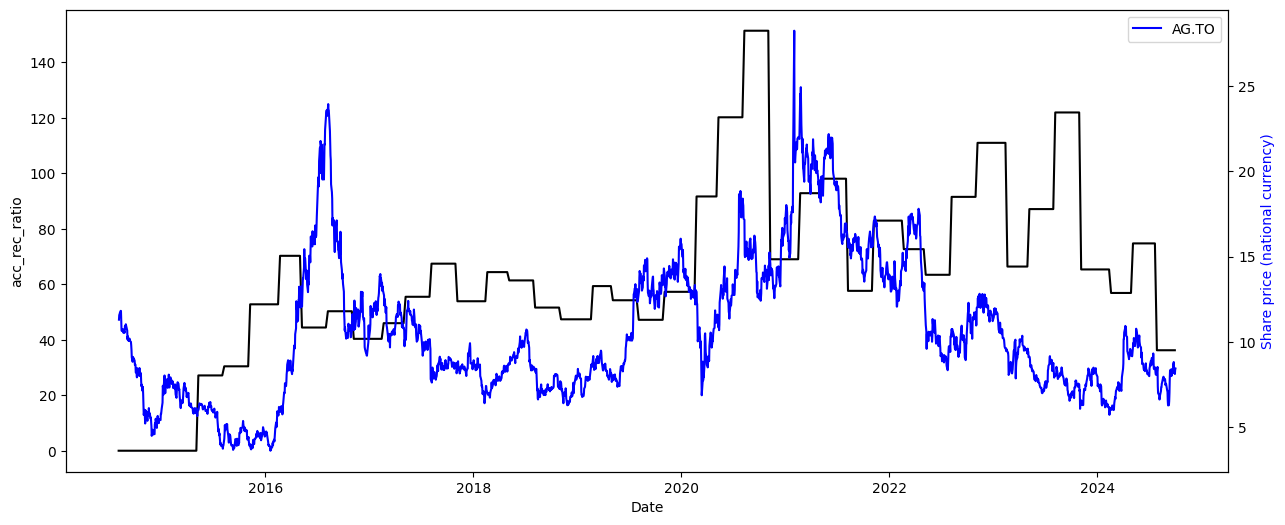

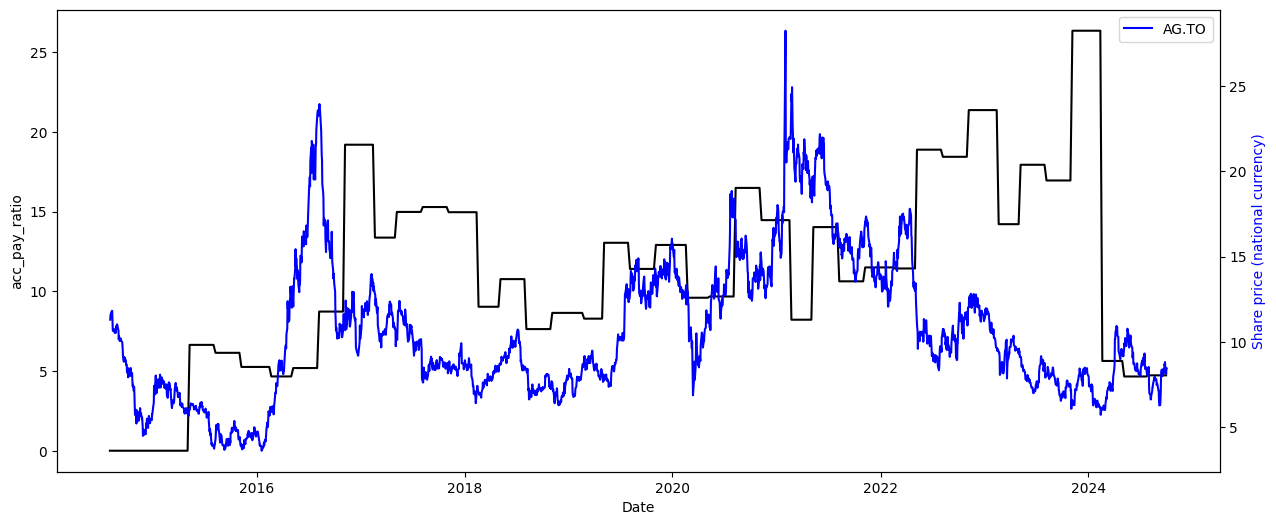

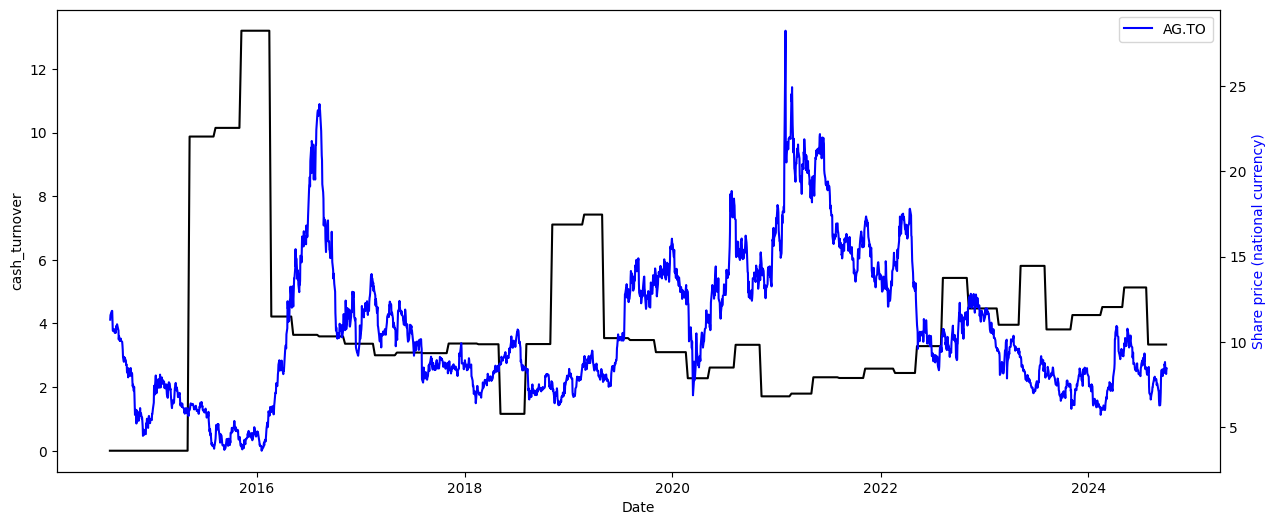

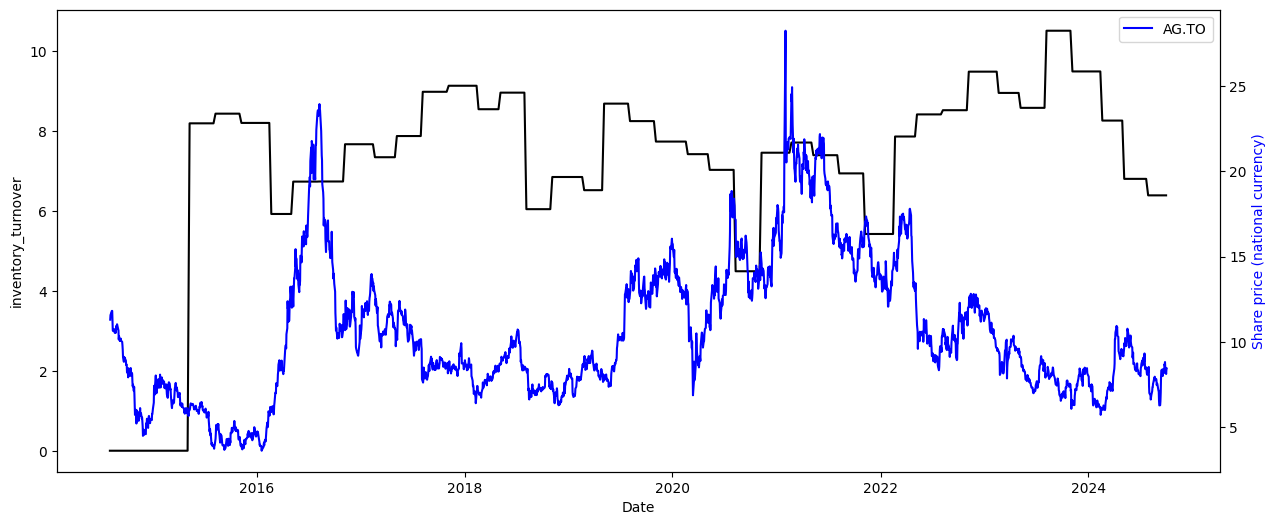

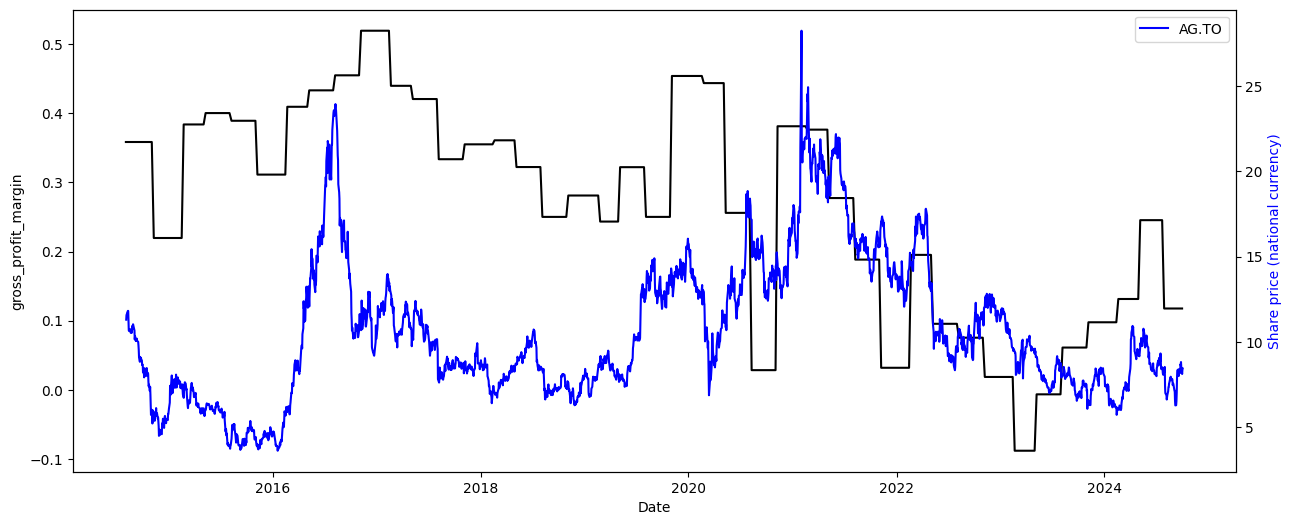

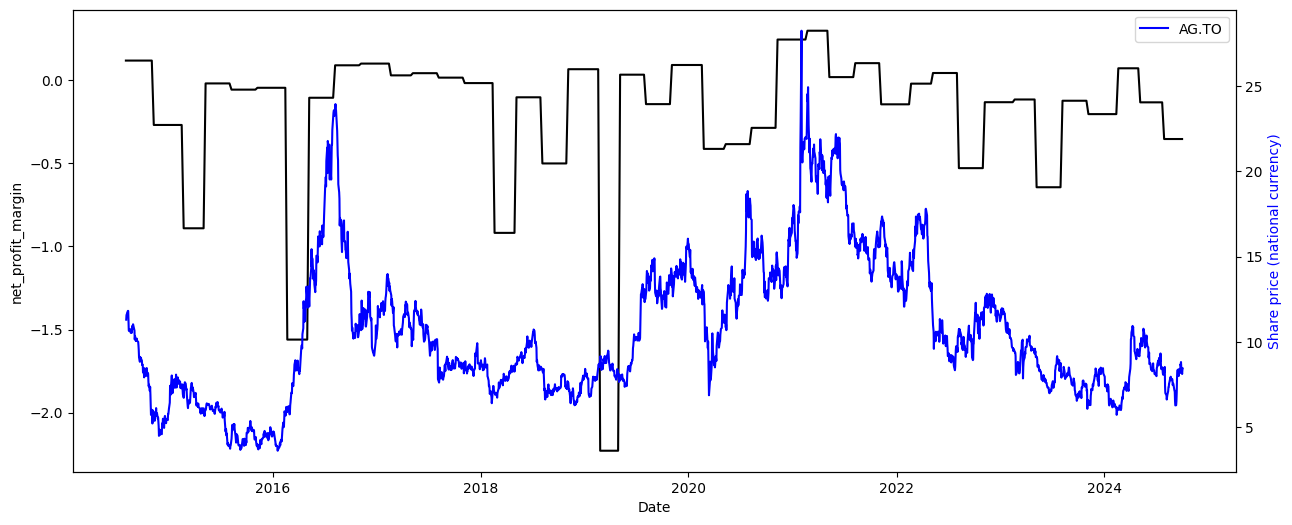

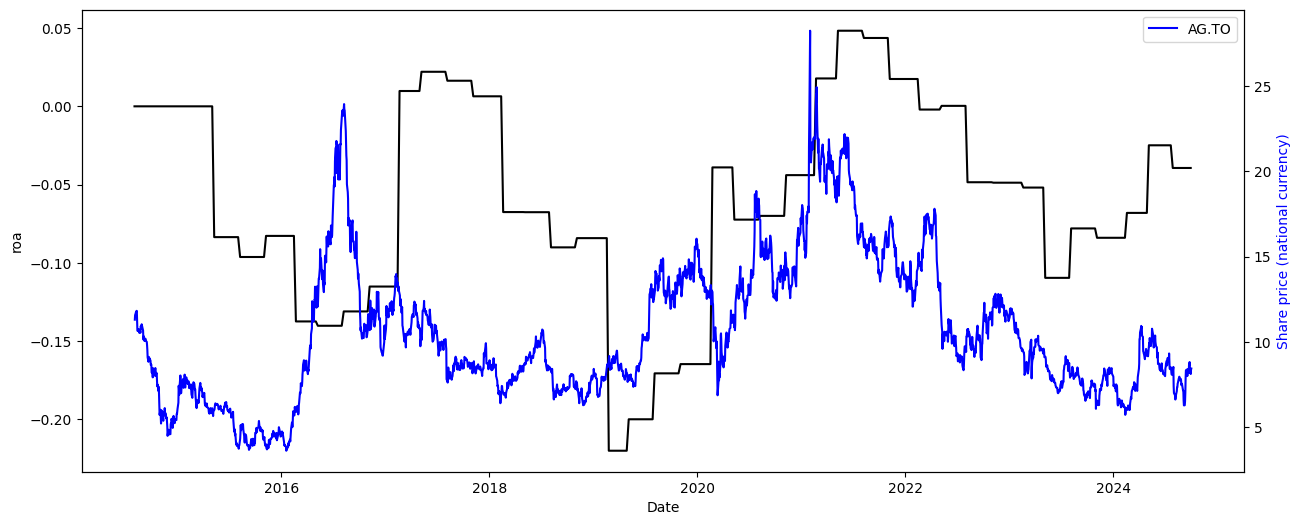

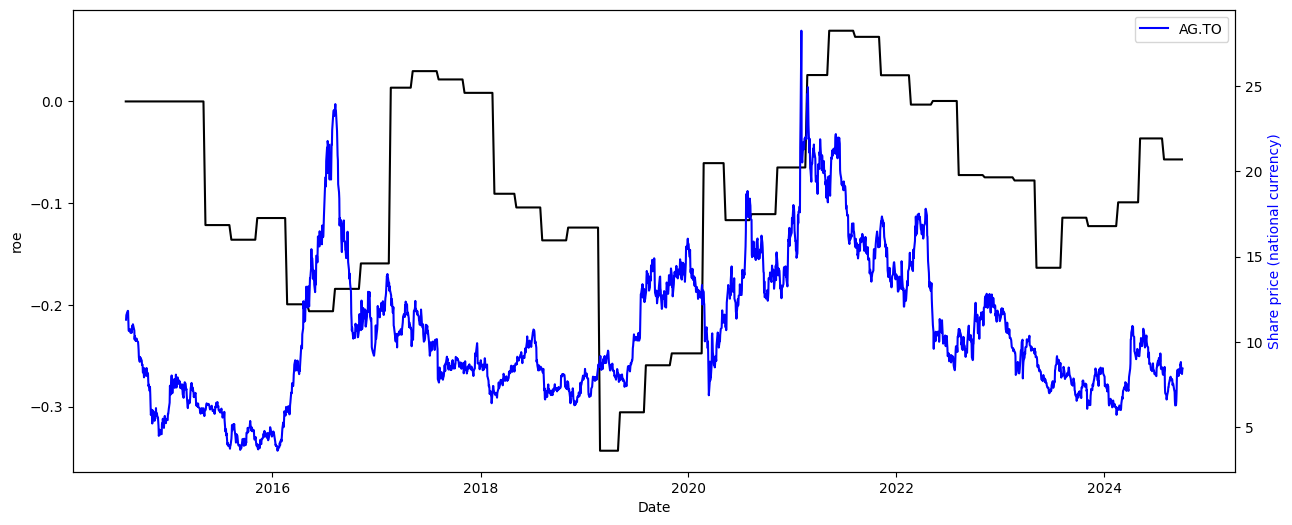

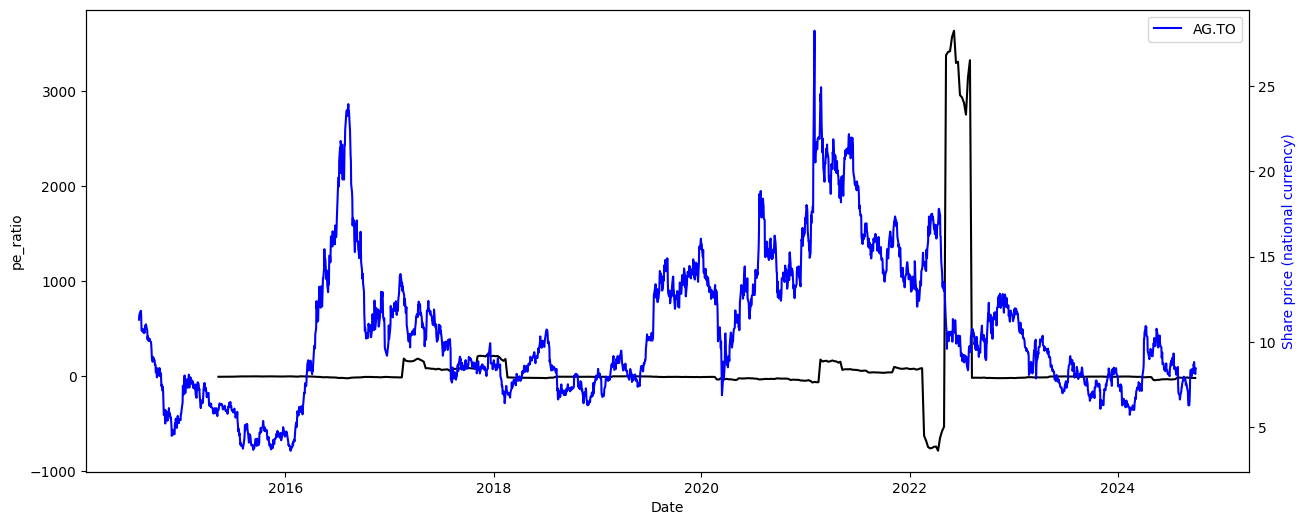

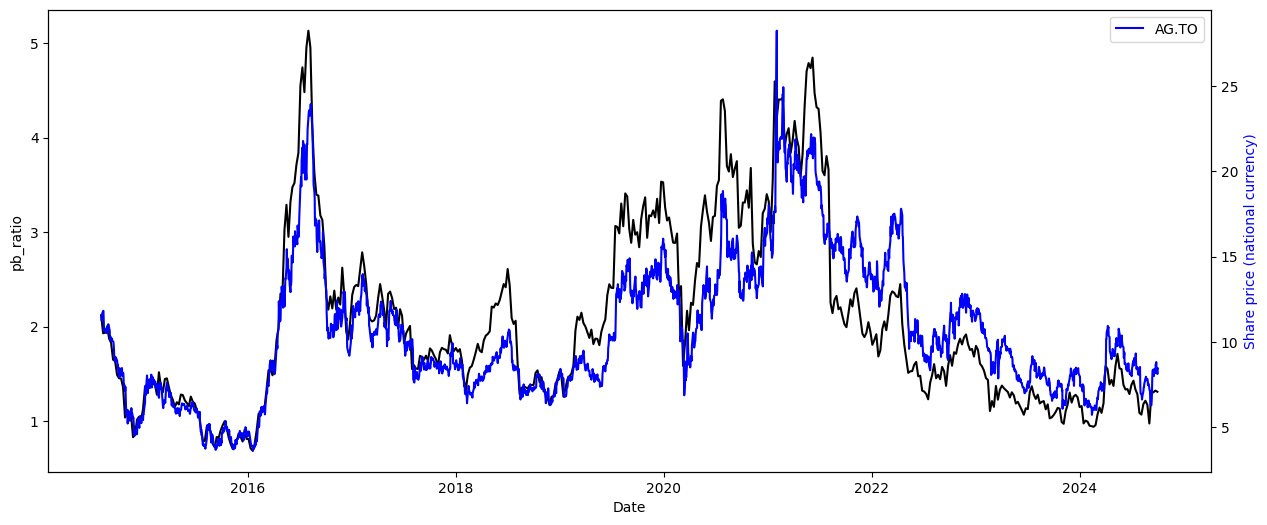

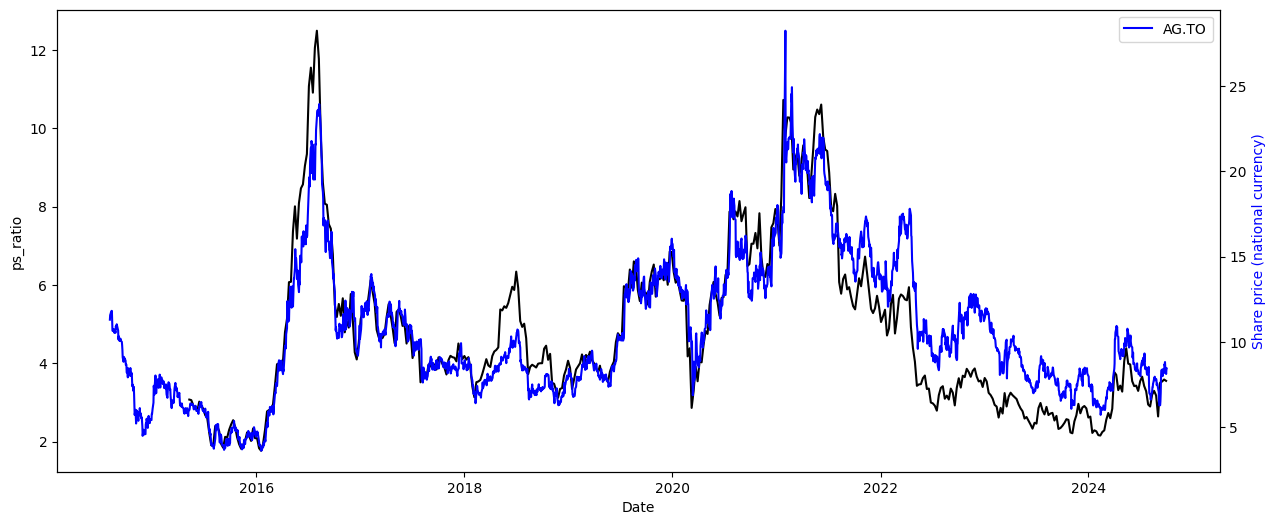

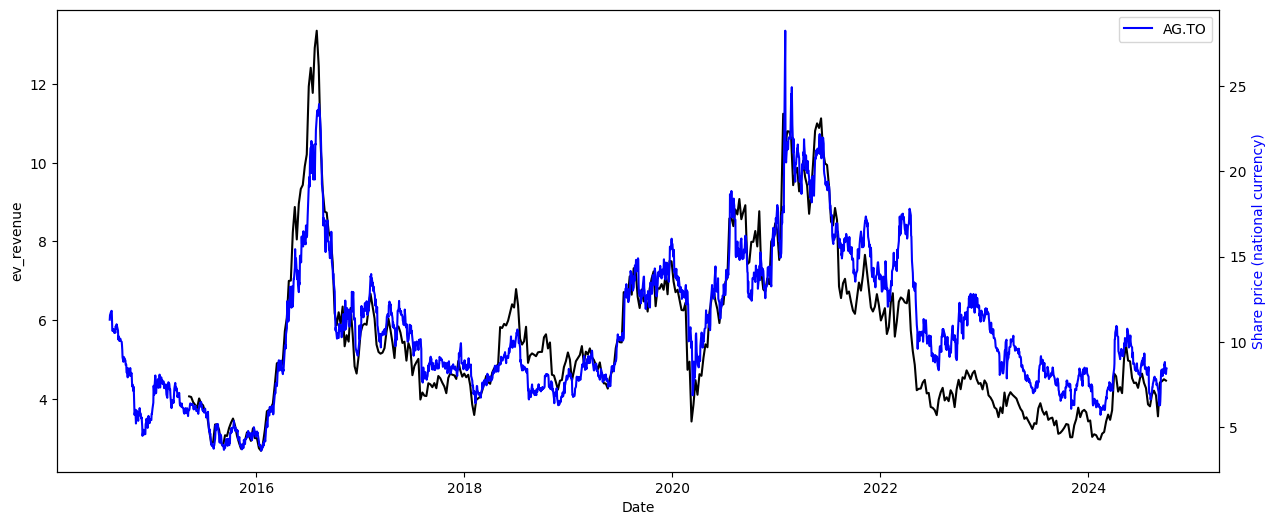

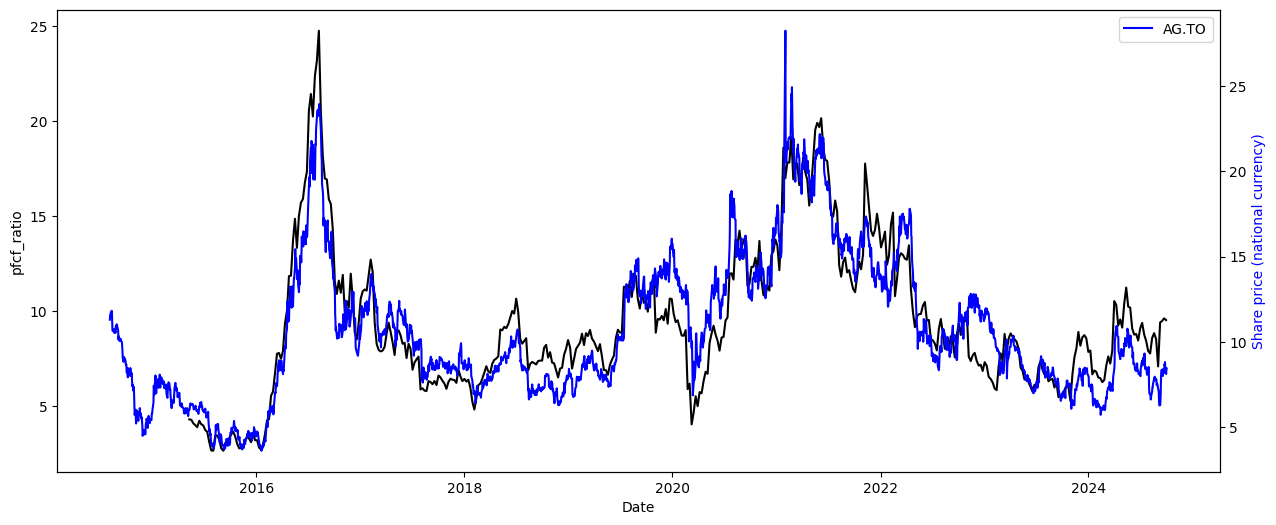

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

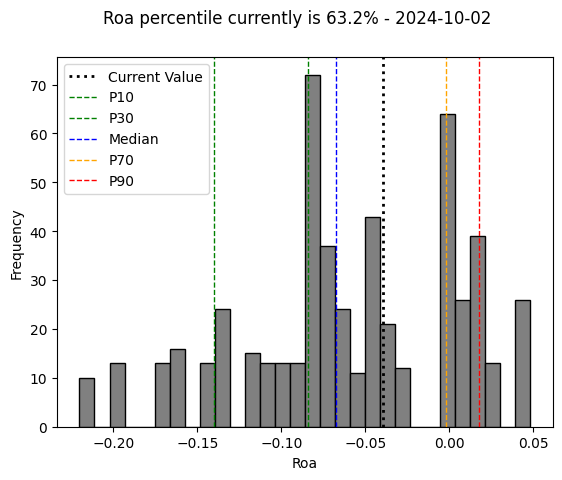

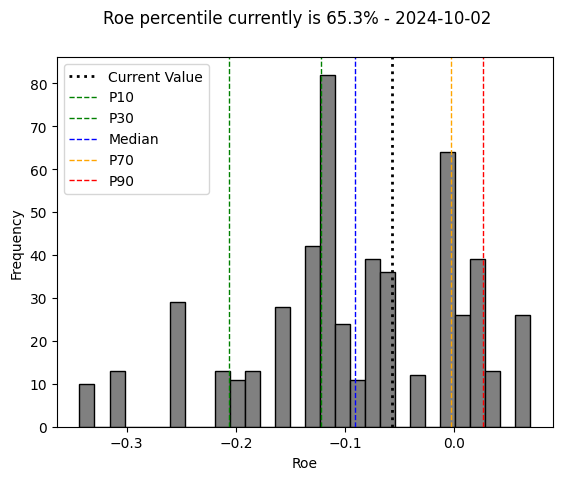

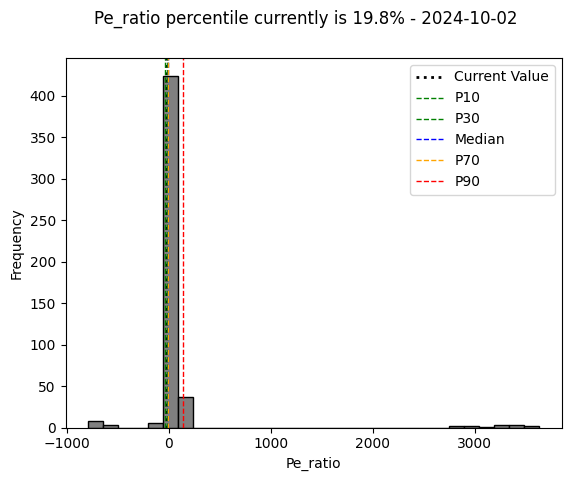

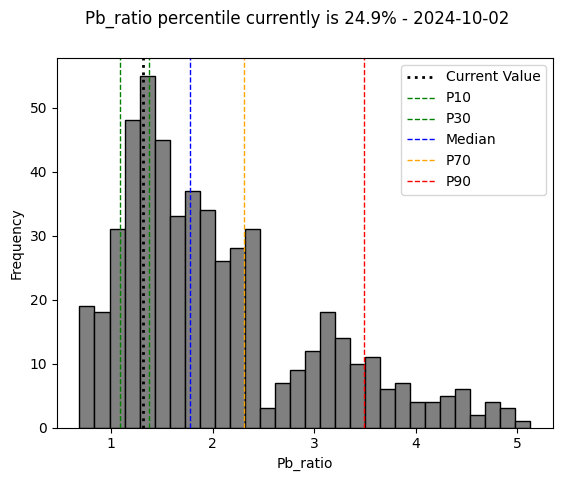

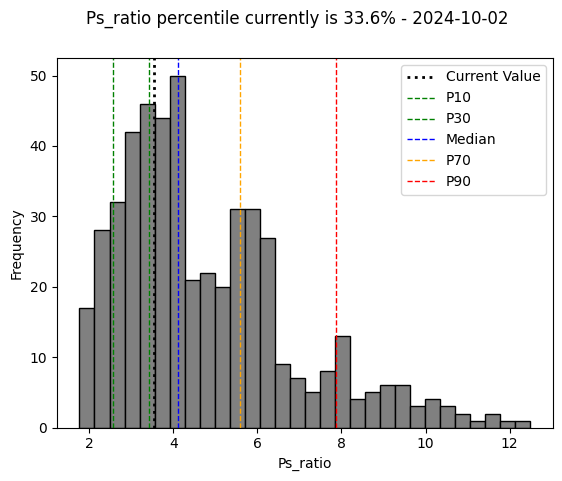

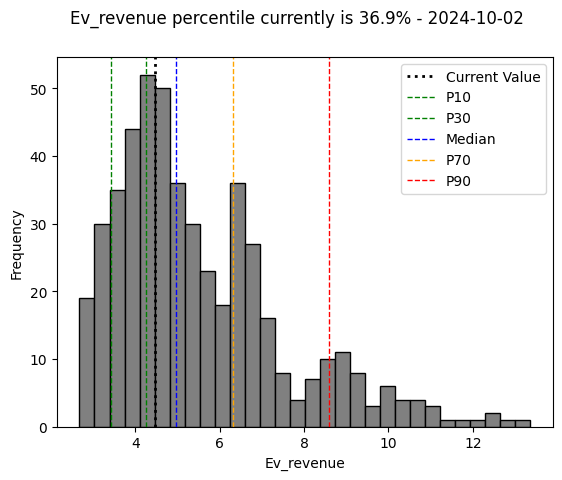

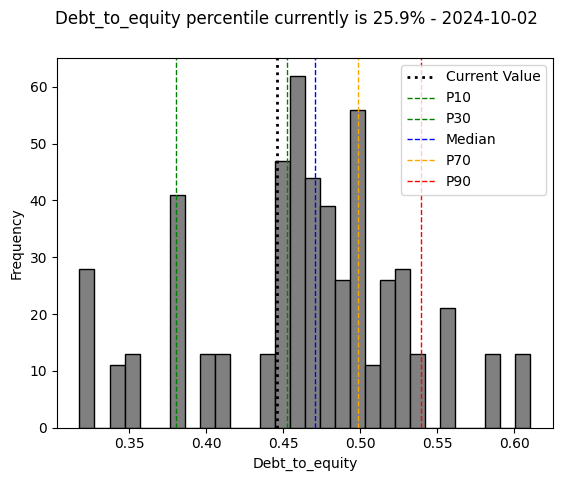

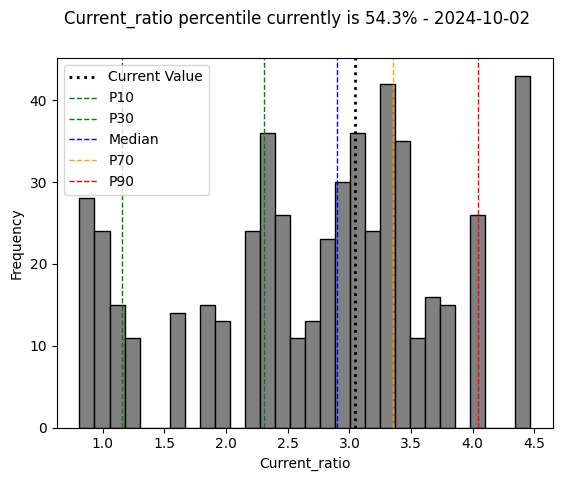

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.998625,0.189282,-0.066783,0.078641,0.049601,-0.295867,0.033246
roe,0.998625,1.000000,0.188071,-0.080347,0.069487,0.040228,-0.325729,0.023740
pe_ratio,0.189282,0.188071,1.000000,-0.100299,-0.106250,-0.112659,-0.027136,-0.063503
pb_ratio,-0.066783,-0.080347,-0.100299,1.000000,0.965241,0.953908,0.217254,0.425943
ps_ratio,0.078641,0.069487,-0.106250,0.965241,1.000000,0.995625,0.153288,0.376815
ev_revenue,0.049601,0.040228,-0.112659,0.953908,0.995625,1.000000,0.197908,0.322968
debt_to_equity,-0.295867,-0.325729,-0.027136,0.217254,0.153288,0.197908,1.000000,-0.178913
current_ratio,0.033246,0.023740,-0.063503,0.425943,0.376815,0.322968,-0.178913,1.000000


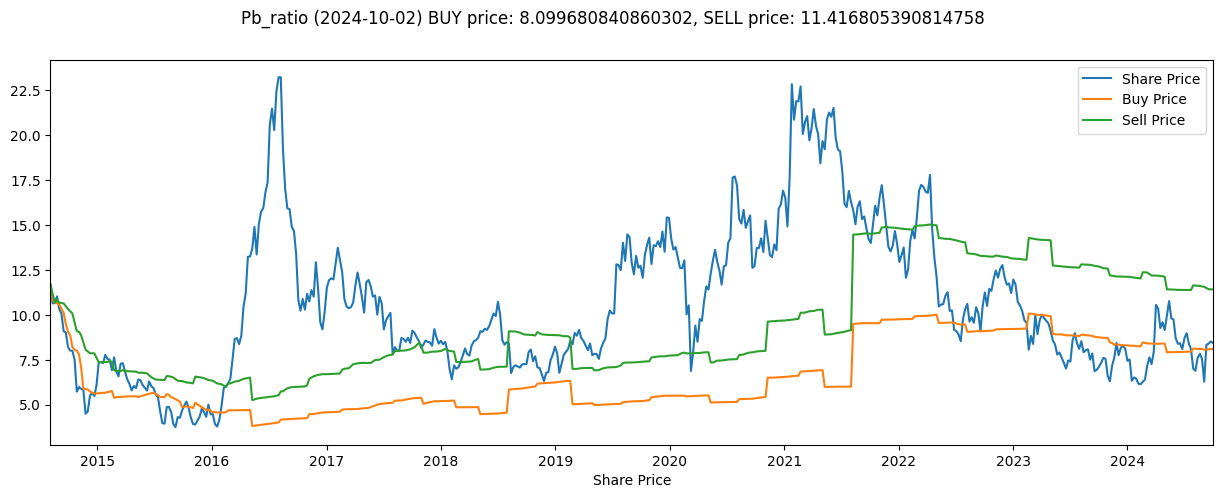

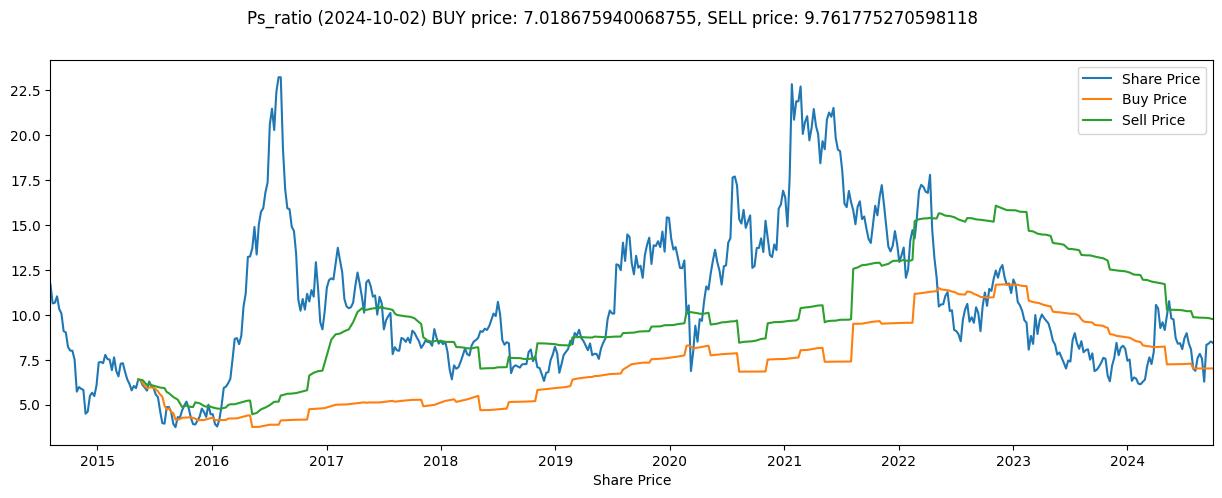

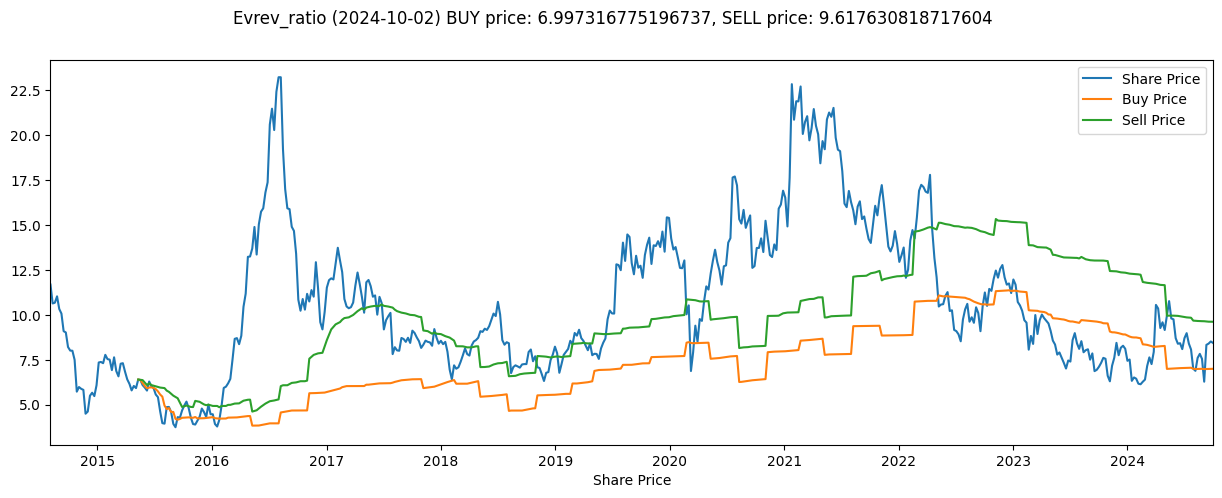

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)